# Load Packages

In [130]:
import nltk
import os
from os import path, getcwd
import random
import numpy as np
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re
import gc; gc.enable()
sns.set()
pd.set_option("display.max_columns",None)

In [2]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/rileyjefferson/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Load
- Analyze english tweets with Vader Sentiment Analysis

In [3]:
df = pd.read_csv('../fw_full.csv',low_memory=False)

In [4]:
df = df[df['lang']=='en']
df.reset_index(drop=True,inplace=True)

In [5]:
df.head(3)

,user_id,status_id,created_at,created_at.1,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,is_retweet,favorite_count,retweet_count,hashtags,symbols,urls_url,urls_t.co,urls_expanded_url,media_url,media_t.co,media_expanded_url,media_type,ext_media_url,ext_media_t.co,ext_media_expanded_url,ext_media_type,mentions_user_id,mentions_screen_name,lang,quoted_status_id,quoted_text,quoted_created_at,quoted_source,quoted_favorite_count,quoted_retweet_count,quoted_user_id,quoted_screen_name,quoted_name,quoted_followers_count,quoted_friends_count,quoted_statuses_count,quoted_location,quoted_description,quoted_verified,retweet_status_id,retweet_text,retweet_created_at,retweet_source,retweet_favorite_count,retweet_retweet_count,retweet_user_id,retweet_screen_name,retweet_name,retweet_followers_count,retweet_friends_count,retweet_statuses_count,retweet_location,retweet_description,retweet_verified,place_url,place_name,place_full_name,place_type,country,country_code,geo_coords,coords_coords,bbox_coords,status_url,name,location,description,url,protected,followers_count,friends_count,listed_count,statuses_count,favourites_count,account_created_at,verified,profile_url,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url
0,x538238041,x1130947670040883200,2019-05-21 21:25,9:25:00 PM,7KingdomsRMine,@ellariasnake *swoops in and hugs forever*,Twitter for Android,28,x1130947259846127616,x2466814554,ellariasnake,False,False,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x2466814554,ellariasnake,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA NA,NA NA,NA NA NA NA NA NA NA NA,https://twitter.com/7KingdomsRMine/status/1130...,Vissie III of the House Targaryen,The seven hells,Fabulous dead king. Don't hate me because I wo...,https://t.co/Aet5yhXkVA,False,10638,326,62,43773,13547,2012-03-27 15:17,False,https://t.co/Aet5yhXkVA,http://vissie4king.com,NaN,https://pbs.twimg.com/profile_banners/53823804...,http://abs.twimg.com/images/themes/theme4/bg.gif,http://pbs.twimg.com/profile_images/7997334059...
1,x538238041,x1130578559242821632,2019-05-20 20:58,8:58:00 PM,7KingdomsRMine,@danygonebad @MaekarTarg *brings the gin tonic*,Twitter for Android,22,x1130577205225033733,x607150882,danygonebad,False,False,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x607150882 x890587538473267200,danygonebad MaekarTarg,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA NA,NA NA,NA NA NA NA NA NA NA NA,https://twitter.com/7KingdomsRMine/status/1130...,Vissie III of the House Targaryen,The seven hells,Fabulous dead king. Don't hate me because I wo...,https://t.co/Aet5yhXkVA,False,10638,326,62,43773,13547,2012-03-27 15:17,False,https://t.co/Aet5yhXkVA,http://vissie4king.com,NaN,https://pbs.twimg.com/profile_banners/53823804...,http://abs.twimg.com/images/themes/theme4/bg.gif,http://pbs.twimg.com/profile_images/7997334059...
2,x538238041,x1130578318422663169,2019-05-20 20:57,8:57:00 PM,7KingdomsRMine,@Sunspear_Snake A mere spot of bother for my n...,Twitter for Android,36,x1130573147420254208,x750065186380406785,Sunspear_Snake,False,False,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x750065186380406785,Sunspear_Snake,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA NA,NA NA,NA NA NA NA NA NA NA NA,https://twitter.com/7KingdomsRMine/status/1130...,Vissie III of the House Targaryen,The seven hells,Fabulous dead king. Don't hate me because I wo...,https://t.co/Aet5yhXkVA,False,10638,326,62,43773,13547,2012-03-27 15:17,False,https://t.co/Aet5yhXkVA,http://vissie4king.com,NaN,https://pbs.twimg.com/profile_banners/53823804...,http://abs.twimg.com/images/themes/them

# Tweet Length Distribution

In [6]:
tweets = pd.DataFrame(df['text'])

In [7]:
tweets['text'].apply(len).describe()

count    33532.000000
mean       109.438596
std         72.443352
min          4.000000
25%         59.000000
50%         88.000000
75%        138.000000
max       1914.000000
Name: text, dtype: float64

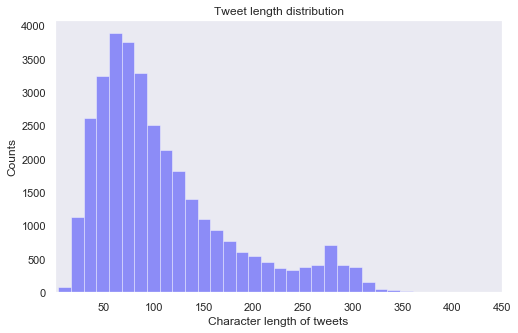

In [10]:
text_lens = tweets['text'].apply(len).values
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
g = sns.distplot(text_lens, kde=False, bins=150, color='blue')
g.set_xlabel('Character length of tweets')
g.set_ylabel('Counts')
g.set_title('Tweet length distribution')
ax.set_xlim(1,450)
ax.grid(False)
plt.show()

# Wordcloud

In [181]:
# remove noise (links)
tweets['text'] = tweets['text'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

In [182]:
# characters in tweets to replace
char_encoding = pd.read_csv('character conversion.csv')

In [183]:
emoji_encoding = pd.read_csv('emoji encoding.csv')

In [184]:
emoji_encoding.head(2)

,Char_conversion,Description,Full Description,Encoded Byte,Twitter_data
0,ðŸŒ€,CYCLONE,CYCLONE <U+1F300>,0001f300,<U+1f300>
1,ðŸŒ,FOGGY,FOGGY <U+1F301>,0001f301,<U+1f301>


In [185]:
tweets['text'] = tweets['text'].str.replace('â','')
for i in range(len(char_encoding)):
    # replace emojis and certain characters with a better description
    tweets['text'] = tweets['text'].str.replace(char_encoding['char_conversion'][i],char_encoding['replace'][i])
    tweets['text'] = tweets['text'].str.replace(emoji_encoding['Char_conversion'][i],emoji_encoding['Description'][i])

In [186]:
# Collate the tweets into a larger one
tweets_concat = " ".join(tweet for tweet in tweets['text'])
stopwords = set(STOPWORDS)

In [187]:
# additional stopwords provided
stopwords2 = pd.read_csv('stopwords_gots8.csv',header=None)

In [188]:
stopwords |= set(stopwords2[0])

In [189]:
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
got_mask = np.array(Image.open(path.join(d, "got_throne.jpg")))

In [190]:
wc = WordCloud(background_color="white", max_words=500, mask=got_mask,
               stopwords=stopwords, contour_width=5.5, contour_color='black',
              margin=10)

# generate word cloud
wc.generate(tweets_concat)

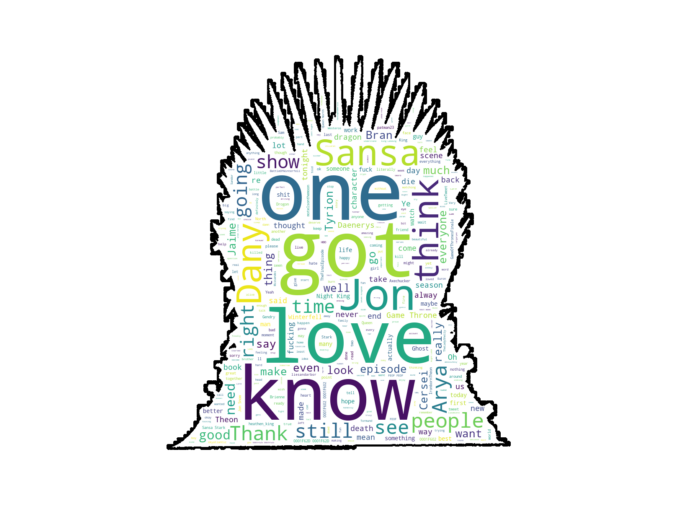

In [191]:
plt.figure(figsize=(12,12))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# Sentiment Analysis

In [253]:
sent_tweets = pd.DataFrame(df[['user_id','followers_count',
                               'text','created_at','source',
                              'screen_name']])

In [254]:
# Append the polarity scores
sid = SentimentIntensityAnalyzer()
sent_list = []
for index, row in tweets.iterrows():
    ss = sid.polarity_scores(row["text"])
    sent_list.append(ss)
sent_tweets['polarity'] = pd.Series(sent_list).values

In [255]:
sent_tweets = pd.concat([sent_tweets,sent_tweets.polarity.apply(pd.Series)],axis=1)

In [256]:
sent_tweets.sample(n=3)

,user_id,followers_count,text,created_at,source,screen_name,polarity,neg,neu,pos,compound
26034,x1282434895,8922,@NiceQueenCersei Wild guess.,2019-04-16 15:25,Twitter for iPhone,TheLadySansa,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
3562,x2466814554,806,"@kinda_cool @heathen_king Quite the opposite, ...",2019-05-06 14:41,Twitter for iPhone,ellariasnake,"{'neg': 0.119, 'neu': 0.703, 'pos': 0.177, 'co...",0.119,0.703,0.177,0.2263
3957,x398694615,539,"Less than an hour, folks. The realm us buzzing...",2019-05-20 0:11,Twitter for iPhone,FatPinkMast,"{'neg': 0.138, 'neu': 0.724, 'pos': 0.138, 'co...",0.138,0.724,0.138,0.0000


# EDA I 
- Episode by episode sentiments (dates from IMDB)

In [258]:
def pseudo_date(df,date1,date2,ep_name):
    df.loc[(df['created_at']>=date1) &
           (df['created_at']<date2),'created_date_pseudo'] = '%s' %(ep_name)
    return df

In [259]:
sent_tweets['created_date_pseudo'] = 'Pre Episode 1'
sent_tweets = pseudo_date(sent_tweets,'2019-04-14','2019-04-21','S8 Episode 1')
sent_tweets = pseudo_date(sent_tweets,'2019-04-21','2019-04-28','S8 Episode 2')
sent_tweets = pseudo_date(sent_tweets,'2019-04-28','2019-05-05','S8 Episode 3')
sent_tweets = pseudo_date(sent_tweets,'2019-05-05','2019-05-12','S8 Episode 4')
sent_tweets = pseudo_date(sent_tweets,'2019-05-12','2019-05-19','S8 Episode 5')
sent_tweets = pseudo_date(sent_tweets,'2019-05-19','2019-05-26','S8 Episode 6')

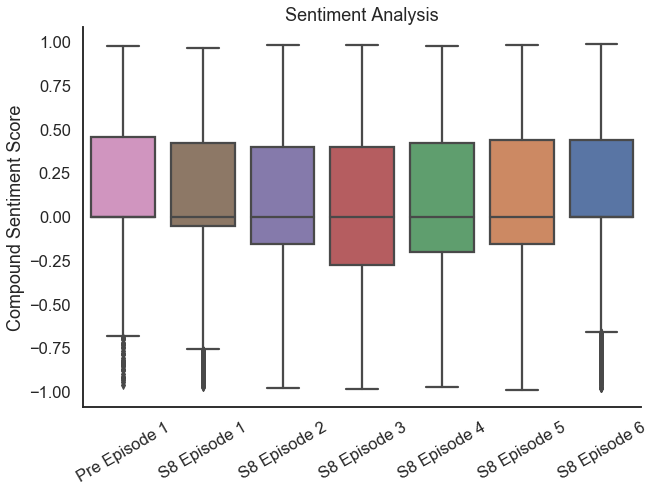

In [199]:
sns.set_context("talk")
sns.set_style("white")
plt.figure(figsize=(10,7))
ax = sns.boxplot(x="created_date_pseudo", y="compound",data=sent_tweets)
ax.invert_xaxis()
ax.set(xlabel='', ylabel='Compound Sentiment Score',
       title='Sentiment Analysis')
locs, labels = plt.xticks()
plt.setp(labels, rotation=30)
sns.despine()
plt.show()

In [200]:
sent_tweets['Tweet Source'] = 'Other'
sent_tweets.loc[sent_tweets['source']=='Twitter for Android','Tweet Source'] = 'Android'
sent_tweets.loc[sent_tweets['source']=='Twitter for iPhone','Tweet Source'] = 'iPhone'
sent_tweets.loc[(sent_tweets['source']=='Twitter Web Client') |
           (sent_tweets['source']=='Twitter Web App'), 'Tweet Source'] = 'Web'

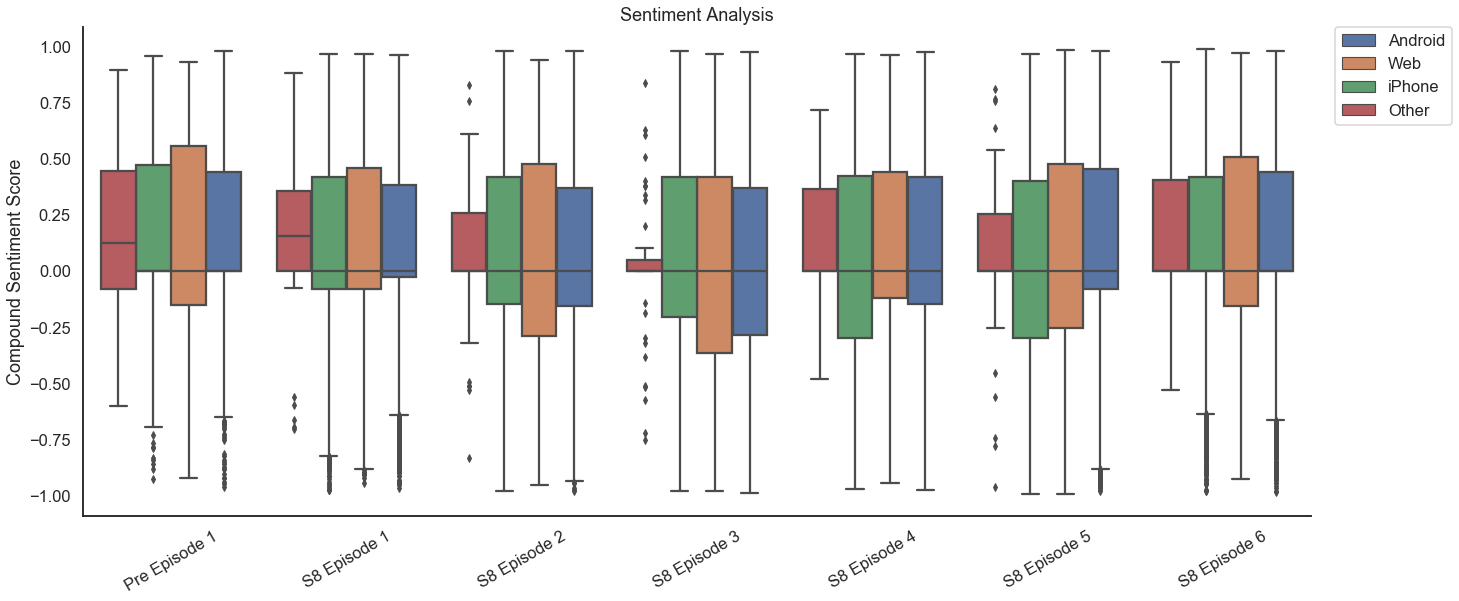

In [201]:
sns.set_context("talk")
sns.set_style("white")
plt.figure(figsize=(22,9))
ax = sns.boxplot(x="created_date_pseudo", y="compound",
                 hue='Tweet Source',data=sent_tweets)
ax.invert_xaxis()
ax.set(xlabel='', ylabel='Compound Sentiment Score',
       title='Sentiment Analysis')
locs, labels = plt.xticks()
plt.setp(labels, rotation=30)
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
sns.despine()
plt.show()

# Follower Count Influence

In [217]:
df_combine = pd.concat([df,sent_tweets.iloc[:,3:]],axis=1)

In [218]:
df_fci = df_combine[['user_id','favorite_count','favourites_count','followers_count','compound']]

In [219]:
infl = df_fci.groupby(['user_id']).agg({'followers_count':'mean',
                                        'compound':'mean'}).sort_values(by=['followers_count'],
                                                                                    ascending=False)

In [220]:
infl.reset_index(drop=True,inplace=True)

In [223]:
# going to bin follower counts, could use qcut but I dislike it.
infl['follower bin'] = '0 to 1000 followers'
infl.loc[(infl['followers_count']>1000)&
        (infl['followers_count']<10000),'follower_bin'] = '1000 to 10000 followers'
infl.loc[(infl['followers_count']>=10000)&
        (infl['followers_count']<50000),'follower_bin'] = '10000 to 50000 followers'
infl.loc[(infl['followers_count']>=50000),'follower_bin'] = '50000+ followers'

In [225]:
infl.rename(columns={'compound':'mean_compound'},inplace=True)

In [226]:
infl.sample(n=3)

,followers_count,mean_compound,follower bin,follower_bin
0,105966.463415,0.043888,0 to 1000 followers,50000+ followers
5,33022.927618,0.039371,0 to 1000 followers,10000 to 50000 followers
14,9365.302590,0.068395,0 to 1000 followers,1000 to 10000 followers


In [227]:
infl_bins = infl.groupby(['follower_bin'])['mean_compound'].mean().reset_index().sort_values(by=['mean_compound'],
                                                                               ascending=False)

In [228]:
infl_bins

,follower_bin,mean_compound
0,1000 to 10000 followers,0.095439
1,10000 to 50000 followers,0.051117
2,50000+ followers,0.031432


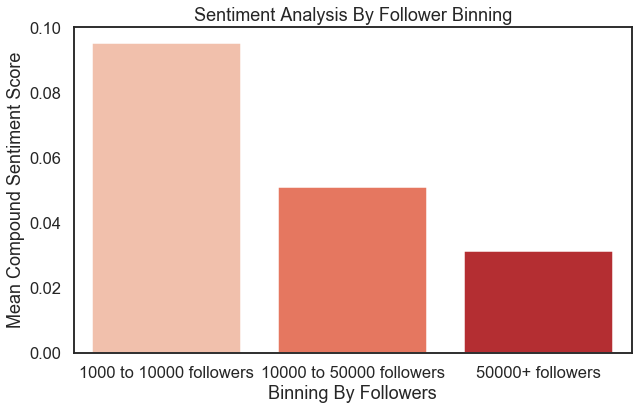

In [244]:
sns.set_context("talk")
plt.figure(figsize=(10,6))
ax = sns.barplot(x="follower_bin", y="mean_compound", data=infl_bins,
                palette='Reds')
ax.set(xlabel='Binning By Followers', ylabel='Mean Compound Sentiment Score',
       title='Sentiment Analysis By Follower Binning')
plt.show()

# Per User Analysis

In [279]:
value1 = sent_tweets.groupby(['user_id','created_date_pseudo']).agg({'compound':'mean',
                                                           'text':'count'}).reset_index()

In [280]:
value1 = pd.merge(value1,sent_tweets[['user_id','followers_count','screen_name']].drop_duplicates(['user_id']))

In [281]:
value1 = value1.sort_values(by=['followers_count','user_id'],ascending=[False,True])

In [283]:
value1.rename(columns={'text':'number of tweets',
                      'compound':'mean compound score'},
             inplace=True)

In [285]:
value1.head(20)

,user_id,created_date_pseudo,mean compound score,number of tweets,followers_count,screen_name
191,x710782219,Pre Episode 1,0.072372,39,106845,Arya_No1
192,x710782219,S8 Episode 1,0.123286,97,106845,Arya_No1
193,x710782219,S8 Episode 2,0.019573,92,106845,Arya_No1
194,x710782219,S8 Episode 3,0.099285,106,106845,Arya_No1
195,x710782219,S8 Episode 4,0.052493,121,106845,Arya_No1
196,x710782219,S8 Episode 5,-0.064342,161,106845,Arya_No1
197,x710782219,S8 Episode 6,0.092483,81,106845,Arya_No1
95,x304411861,Pre Episode 1,-0.205000,6,100557,Margaery_Tyrell
96,x304411861,S8 Episode 1,0.047533,98,100557,Margaery_Tyrell
97,x304411861,S8 Episode 2,0.005923,43,100557,Margaery_Tyrell
